# ScBasset: Scoring TF activity using motif injection

```{warning}
SCBASSET's development is still in progress. The current version may not fully reproduce the original implementation's results.
```

In addition to performing representation learning on scATAC-seq data, scBasset can also be used to estimate the activity of transcription factors based on their motif sequences. This tutorial walks through the following:

1. Loading the dataset
2. Preprocessing the dataset with scanpy
3. Setting up and training the model
4. Visualizing the latent space with scanpy
5. Estimating TF activities using motif injection
6. Visualizing TF activity scores in the latent space

In [1]:
!pip install --quiet scvi-colab muon
from scvi_colab import install

install(branch="main")

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
import matplotlib.pyplot as plt
import muon
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns

In [3]:
scvi.settings.seed = 0

sc.set_figure_params(figsize=(4, 4), frameon=False)

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

INFO: Global seed set to 0
INFO:lightning.fabric.utilities.seed:Global seed set to 0


## Loading data and preprocessing

Throughout this tutorial, we use [sample multiome data from 10X of 10K PBMCs](https://www.10xgenomics.com/resources/datasets/10-k-human-pbm-cs-multiome-v-1-0-chromium-x-1-standard-2-0-0).

In [4]:
url = "https://cf.10xgenomics.com/samples/cell-arc/2.0.0/10k_PBMC_Multiome_nextgem_Chromium_X/10k_PBMC_Multiome_nextgem_Chromium_X_filtered_feature_bc_matrix.h5"
mdata = muon.read_10x_h5("data/multiome10k.h5mu", backup_url=url)

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from data/multiome10k.h5mu


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/mudata/_core/mudata.py:445: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


In [5]:
mdata

MuData object with n_obs × n_vars = 10970 × 148344
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	10970 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	10970 x 111743
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

In [6]:
adata = mdata.mod["atac"]

We can use scanpy functions to handle, filter, and manipulate the data. In our case, we might want to filter out peaks that are rarely detected, to make the model train faster:

In [7]:
print(adata.shape)
# compute the threshold: 5% of the cells
min_cells = int(adata.shape[0] * 0.05)
# in-place filtering of regions
sc.pp.filter_genes(adata, min_cells=min_cells)
print(adata.shape)

(10970, 111743)
(10970, 37054)


In [8]:
adata.var

,gene_ids,feature_types,genome,interval,n_cells
chr1:629395-630394,chr1:629395-630394,Peaks,GRCh38,chr1:629395-630394,1422
chr1:633578-634591,chr1:633578-634591,Peaks,GRCh38,chr1:633578-634591,4536
chr1:778283-779200,chr1:778283-779200,Peaks,GRCh38,chr1:778283-779200,5981
chr1:816873-817775,chr1:816873-817775,Peaks,GRCh38,chr1:816873-817775,564
chr1:827067-827949,chr1:827067-827949,Peaks,GRCh38,chr1:827067-827949,3150
...,...,...,...,...,...
GL000219.1:44739-45583,GL000219.1:44739-45583,Peaks,GRCh38,GL000219.1:44739-45583,781
GL000219.1:45726-46446,GL000219.1:45726-46446,Peaks,GRCh38,GL000219.1:45726-46446,639
GL000219.1:99267-100169,GL000219.1:99267-100169,Peaks,GRCh38,GL000219.1:99267-100169,6830
KI270726.1:41483-42332,KI270726.1:41483-42332,Peaks,GRCh38,KI270726.1:41483-42332,605


In [9]:
split_interval = adata.var["gene_ids"].str.split(":", expand=True)
adata.var["chr"] = split_interval[0]
split_start_end = split_interval[1].str.split("-", expand=True)
adata.var["start"] = split_start_end[0].astype(int)
adata.var["end"] = split_start_end[1].astype(int)
adata.var

,gene_ids,feature_types,genome,interval,n_cells,chr,start,end
chr1:629395-630394,chr1:629395-630394,Peaks,GRCh38,chr1:629395-630394,1422,chr1,629395,630394
chr1:633578-634591,chr1:633578-634591,Peaks,GRCh38,chr1:633578-634591,4536,chr1,633578,634591
chr1:778283-779200,chr1:778283-779200,Peaks,GRCh38,chr1:778283-779200,5981,chr1,778283,779200
chr1:816873-817775,chr1:816873-817775,Peaks,GRCh38,chr1:816873-817775,564,chr1,816873,817775
chr1:827067-827949,chr1:827067-827949,Peaks,GRCh38,chr1:827067-827949,3150,chr1,827067,827949
...,...,...,...,...,...,...,...,...
GL000219.1:44739-45583,GL000219.1:44739-45583,Peaks,GRCh38,GL000219.1:44739-45583,781,GL000219.1,44739,45583
GL000219.1:45726-46446,GL000219.1:45726-46446,Peaks,GRCh38,GL000219.1:45726-46446,639,GL000219.1,45726,46446
GL000219.1:99267-100169,GL000219.1:99267-100169,Peaks,GRCh38,GL000219.1:99267-100169,6830,GL000219.1,99267,100169
KI270726.1:41483-42332,KI270726.1:41483-42332,Peaks,GRCh38,KI270726.1:41483-42332,605,KI270726.1,41483,42332


In [10]:
# Filter out non-chromosomal regions
mask = adata.var["chr"].str.startswith("chr")
adata = adata[:, mask].copy()

In [11]:
scvi.data.add_dna_sequence(
    adata,
    genome_name="GRCh38",
    genome_dir="data",
    chr_var_key="chr",
    start_var_key="start",
    end_var_key="end",
)
adata

Working...: 100%|██████████| 24/24 [00:04<00:00,  5.98it/s]


AnnData object with n_obs × n_vars = 10970 × 37042
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'chr', 'start', 'end'
    varm: 'dna_sequence', 'dna_code'

In [12]:
adata.varm["dna_sequence"]

,0,1,2,3,4,5,6,7,8,9,...,1334,1335,1336,1337,1338,1339,1340,1341,1342,1343
chr1:629395-630394,C,A,C,T,C,T,C,C,C,C,...,C,T,A,T,A,T,C,T,A,A
chr1:633578-634591,G,A,A,A,T,A,G,G,G,C,...,T,A,A,A,T,C,C,C,C,T
chr1:778283-779200,C,G,C,C,C,G,G,C,T,A,...,G,A,C,A,G,G,A,G,T,T
chr1:816873-817775,A,A,T,T,C,A,T,A,T,G,...,T,T,A,G,C,G,G,C,T,G
chr1:827067-827949,C,T,C,T,C,C,T,G,C,C,...,C,G,T,T,A,T,T,A,A,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrY:19077075-19078016,A,C,G,A,C,C,T,C,C,C,...,C,A,T,A,G,T,T,C,T,A
chrY:19567013-19567787,G,G,A,G,T,C,T,G,G,G,...,T,C,T,C,T,T,C,G,T,T
chrY:19744368-19745303,T,A,T,T,T,T,T,G,T,C,...,A,T,G,T,G,G,A,A,A,T
chrY:20575244-20576162,T,T,T,A,C,T,G,T,C,T,...,G,A,G,T,G,T,A,A,C,A


## Creating and training the model

We can now set up the AnnData object, which will ensure everything the model needs is in place for training.

This is also the stage where we can condition the model on additional covariates, which encourages the model to remove the impact of those covariates from the learned latent space. Our sample data is a single batch, so we won't demonstrate this directly, but it can be done simply by setting the `batch_key` argument to the annotation to be used as a batch covariate (must be a valid key in `adata.obs`) .

In [13]:
bdata = adata.transpose()
bdata.layers["binary"] = (bdata.X.copy() > 0).astype(float)
scvi.external.SCBASSET.setup_anndata(bdata, layer="binary", dna_code_key="dna_code")

INFO     Using column names from columns of adata.obsm['dna_code']                                                 


We can now create a scBasset model object and train it!

```{note}
The default max epochs is set to 1000, but in practice scBasset stops early once the model converges, which especially for large datasets (which require fewer epochs to converge, since each epoch includes letting the model view more data).
```

Here we are using 16 bit precision which uses less memory without sacrificing performance.

In [14]:
bas = scvi.external.SCBASSET(bdata)
bas.train(precision=16)

/usr/local/lib/python3.10/dist-packages/lightning/fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float3

Epoch 890/1000:  89%|████████▉ | 890/1000 [1:38:54<12:13,  6.67s/it, v_num=1, train_loss_step=0.362, train_loss_epoch=0.361]
Monitored metric auroc_train did not improve in the last 45 records. Best score: 0.847. Signaling Trainer to stop.


<Axes: xlabel='epoch'>

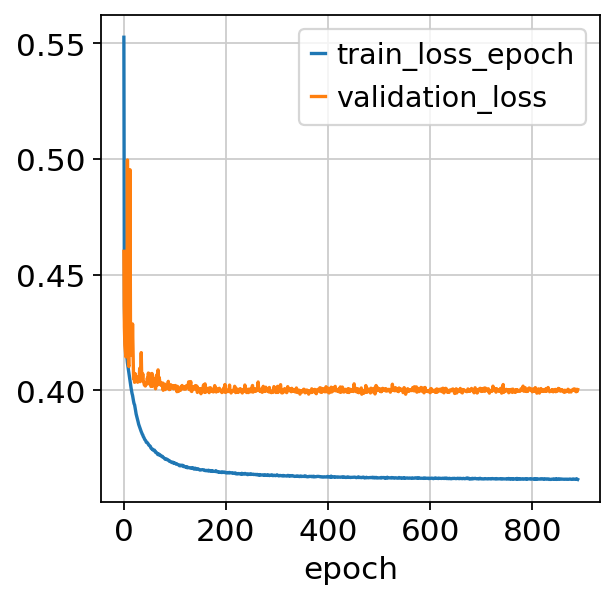

In [15]:
fig, ax = plt.subplots()
bas.history_["train_loss_epoch"].plot(ax=ax)
bas.history_["validation_loss"].plot(ax=ax)

<Axes: xlabel='epoch'>

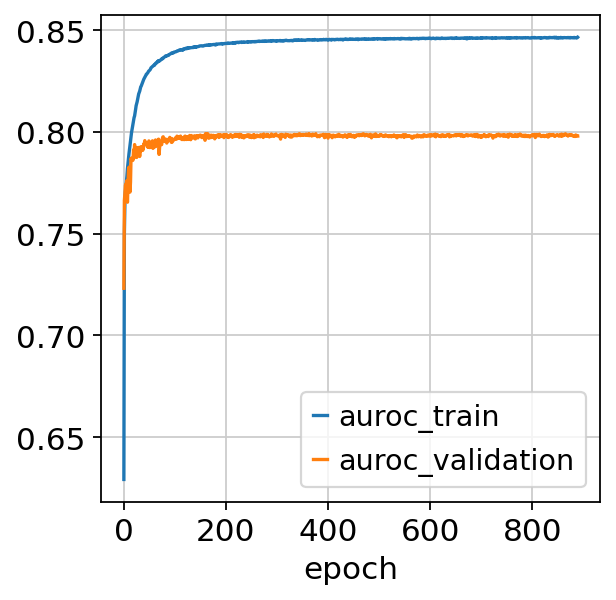

In [16]:
fig, ax = plt.subplots()
bas.history_["auroc_train"].plot(ax=ax)
bas.history_["auroc_validation"].plot(ax=ax)

## Visualizing and analyzing the latent space

We can now use the trained model to visualize, cluster, and analyze the data. We first extract the latent representation from the model, and save it back into our AnnData object:

In [17]:
latent = bas.get_latent_representation()
adata.obsm["X_scbasset"] = latent

print(latent.shape)

(10970, 32)


Text(0, 0.5, 'log10(UMI count)')

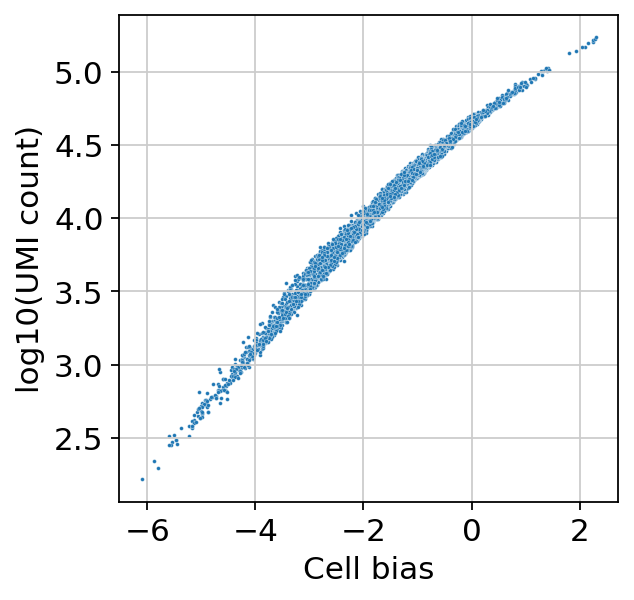

In [18]:
sns.scatterplot(
    x=bas.get_cell_bias(),
    y=np.log10(np.asarray(adata.X.sum(1))).ravel(),
    s=3,
)
plt.xlabel("Cell bias")
plt.ylabel("log10(UMI count)")

We can now use scanpy functions to cluster and visualize our latent space:

In [19]:
# compute the k-nearest-neighbor graph that is used in both clustering and umap algorithms
sc.pp.neighbors(adata, use_rep="X_scbasset")
# compute the umap
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden_scbasset")

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


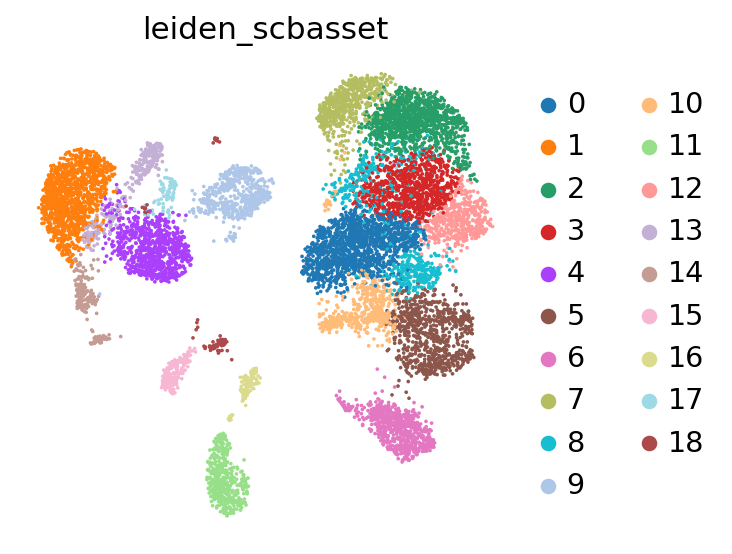

In [20]:
sc.pl.umap(adata, color="leiden_scbasset")

# Score TF activity

We will now use the motif injection procedure to infer the activity of human transcription factors using their motifs. 

This process involves downloading a library of (1) random dinucleotide shuffled sequences and (2) random sequences with a known motif injected. We infer the accessibility of all the random sequences and all the motif injected sequences in every cell using the SCBASSET model. We then compute the difference in activity for the motif injected sequences and the random sequences. This difference serves as an estimate for the likelihood that a given motif is accessible in each cell, and therefore an estimate of a corresponding transcription factor's activity.

Any library with sequences of the appropriate size can be used. By default, we provide the human TF motif library used in the scBasset paper. The library is downloaded to a local folder (default: `./scbasset_motifs`). Each motif is stored in a specific FASTA file in the `{library_path}/shuffled_peaks_motifs` subdirectory. To see all available motifs, simply glob the path (e.g. `Path("./scbasset_motifs/shuffled_peaks_motifs").glob("*.fasta")`).

In [21]:
tfs = ["PAX5", "TCF7", "RXRA"]

In [22]:
for tf in tfs:
  adata.obs[f"bas_{tf}"] = bas.get_tf_activity(tf=tf,)

INFO     Downloading motif set to: scbasset_motifs                                                                 
INFO     Downloading file at scbasset_motifs/human_motifs.tar.gz                                                   
Downloading...: 100%|██████████| 306466/306466.0 [00:16<00:00, 18412.13it/s]
INFO     Download and extraction complete.                                                                         


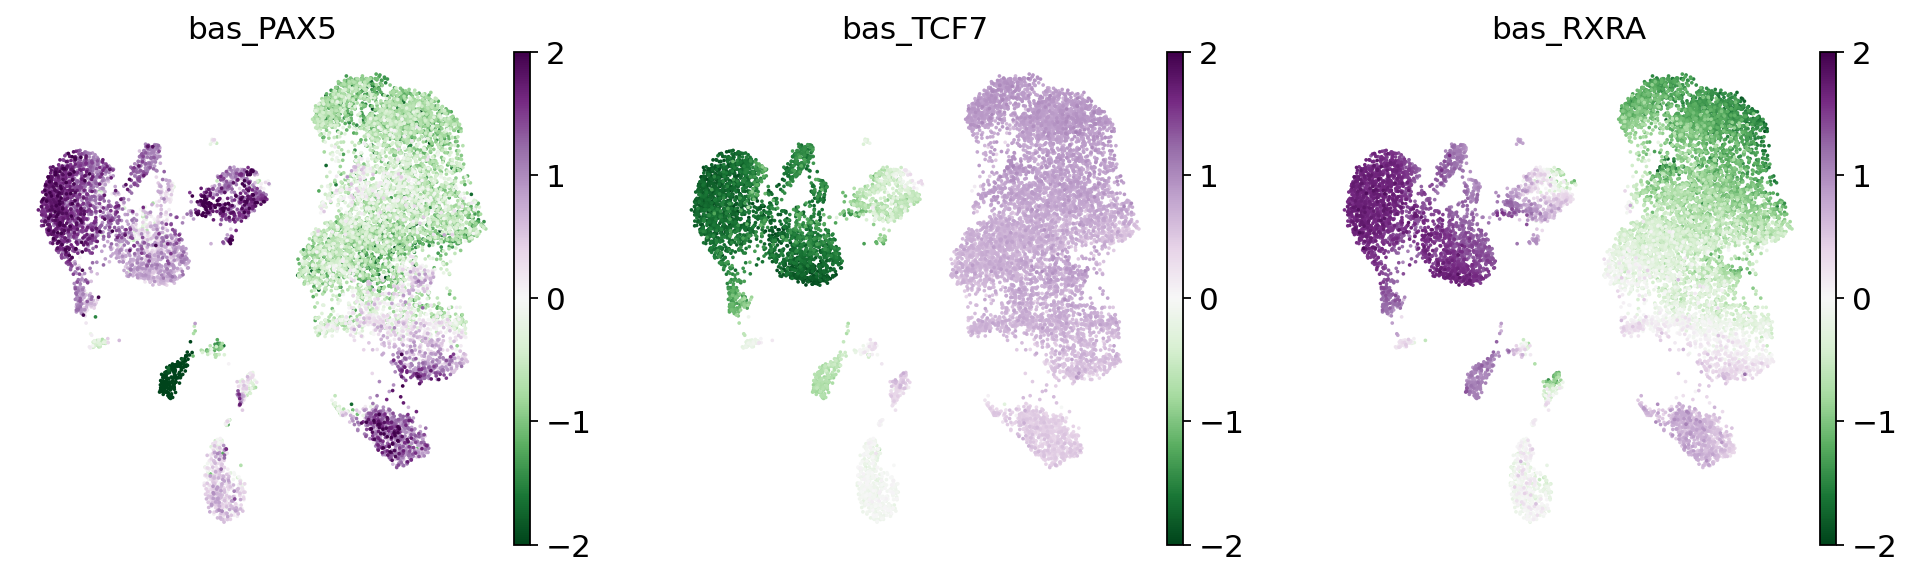

In [23]:
sc.pl.umap(
    adata,
    color=[f"bas_{tf}" for tf in tfs],
    cmap="PRGn_r",
    vmin=-2,
    vmax=2,
)